![](img/575_banner.png)

# Lecture 1: Markov Models 

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan, imports, LO

### Imports 

In [1]:
import os
import re
import sys
import time
from collections import Counter, defaultdict

import IPython
import nltk
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Learning outcomes

From this lesson you will be able to

- Explain the general idea of a language model and name some of its applications. 
- Define Markov chains and explain terminology (states, initial probability distribution over states, and transition matrix) related to Markov chains.
- State Markov assumption.
- Compute the probability of a sequence of states. 
- Compute the probability of being in a state at time $t$. 
- Explain the general idea of a stationary distribution.

<br><br><br><br>

## 1. Language models: motivation

### 1.1 Activity

Each of you will receive a sticky note with a word on it. Here's what you'll do:
- Carefully **remove the sticky note to see the word**. This word is for your eyes only — no peeking, neighbours!
- Think quickly: what word would logically follow the word on the sticky note? **Write this next word on a new sticky note**.
- You have about 20 seconds for this step, so trust your instincts!
- **Pass your predicted word to the person next to you**. Do not pass the word you received from your neighbour forward. Keep the chain going!
- After the last person in your row has finished, **collaboratively arrange your sticky notes on the table to form a complete sentence**.
- Finally, one person from your row will enter the collective sentence into [the Google Doc](https://docs.google.com/document/d/1rF2dTSnccxTJxOc59YiRY6ehXHBwBGsewwb1er1gnFA/edit) next to your row number. (Your row number will be indicated on the first sticky note passed to your row.)

Whichever row generates the most captivating sentence will be rewarded with treats! 🍫

<br><br>

- You've just created a simple Markov model of language!
  
- In predicting the next word from a minimal context, you likely used your linguistic intuition and familiarity with common two-word phrases or collocations.
  
- You could create more coherent sentences by taking into account more context e.g., previous two words or four words or 100 words.
  
- Is it possible to extract similar patterns by analyzing vast amounts of web text and their word co-occurrence frequencies?

This idea was first used by Shannon for characters in The Shannon's game. See this video by [Jordan Boyd-Graber](https://www.youtube.com/watch?v=0shft1gokac) for more information on this. 

One of the most common applications for predicting the next word is the 'smart compose' feature in your emails, text messages, and search engines.

In [2]:
url = "https://ai.googleblog.com/2018/05/smart-compose-using-neural-networks-to.html"

IPython.display.IFrame(url, width=500, height=500)

And we all know the state of the art language model [ChatGPT](https://chat.openai.com)!   
    - Doesn't need any introduction 

These tools are based on the idea of **a language model**. 

<br><br>

### 1.2 What is a language model? 

A language model computes **the probability distribution over sequences of tokens**. Given some vocabulary $V$, a language model assigns a probability (a number between 0 and 1) to all sequences of tokens in $V$. 

Intuitively, this probability tells us how "good" or plausible a sequence of tokens is. 

<!-- A model that computes the probability of a sequence of words (or characters) or the probability of an upcoming word (or character) is called a **language model**. -->

![](img/voice-assistant-ex.png)

<!-- <img src="img/voice-assistant-ex.png" height="1400" width="1400"> -->

Check out this [recent BMO ad](https://www.youtube.com/watch?v=VzqKtAYeJt4).


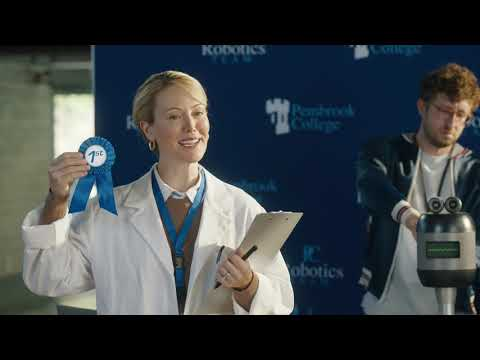

In [3]:
from IPython.display import YouTubeVideo

# Use the video's ID, which is the part after 'v=' in the YouTube video link
video_id = "VzqKtAYeJt4"
YouTubeVideo(video_id, width=700, height=700)

- Compute the probability of a sentence or a sequence of words.
    - $P(w_1, w_2,\dots,w_t)$
    - P(I have read this book) > P(eye have red this book)
    - P(How do I start a savings habit?) > P(How to start shaving a rabbit?)

- A related task: What's the probability of an upcoming word? 
    - $P(w_t|w_1,w_2,\dots,w_{t-1})$ 
    - P(book | read this) > P(book | red this)



<br><br>

### 1.3 Language modeling: Why should we care?

- Powerful idea in NLP and helps in many tasks.

- In recent years, the influence of large language models has expanded significantly, affecting billions of users worldwide. This underscores the importance of understanding the historical context and key principles of language modeling.
- In old days they were used as a component of a larger system. 
    - Machine translation 
        * P(In the age of data algorithms have the answer) > P(the age data of in algorithms answer the have)
    - Spelling correction
        * My office is a 20  <span style="color:red">minuet</span> bike ride from my home.  
            * P(20 <span style="color:blue">minute</span> bike ride from my home) > P(20 <span style="color:red">minuet</span> bike ride from my home)
    - Speech recognition 
        * P(<span style="color:blue">I read</span> a book) > P(<span style="color:red">Eye red</span> a book)
- Now they are capable of being a standalone systems (e.g., ChatGPT)
    - Question answering (e.g., Andrei Markov was born in __)
    - Content generation (e.g., Generating news articles)
    - Summarization
    - Writing assistants (e.g., https://www.ai21.com/)
    - ...

**Why is this hard?**

- Language modeling requires not only linguistic expertise but also extensive world knowledge.
  
- The machine learning models we've studied so far may not be directly suitable because language modeling demands sequence modeling capabilities.
  
- **In this course, we will explore models specifically designed to model sequences effectively.** 
  
- We'll start with the simplest kind of language model: **the Markov model of language**.

- Later in the course, we will talk about neural language models. 
- Today's lecture will delve into the theory behind Markov models. Our next lecture will examine real-world applications of Markov models.

**Markov chains you have seen in MDS so far** 

- DSCI 512
    - You wrote code to generate text using Markov models of language. 
- DSCI 553
    - You used it as a simulation tool to approximate the posterior distribution of your Bayesian modeling parameters of interest.
     
The model we are going to look at is similar to what you've seen in DSCI 512.     

<br><br><br><br>

<br><br>

## 2. Markov model intuition

### 2.1 Does this look like Python code?

```
import sys
import warnings
import ast
import numpy.core.overrides import set_module
# While not in __all__, matrix_power used to be defined here, so we import
# it for backward compatibility
    getT = T.fget
    getI = I.fget
```

```
def _from_string(data):
    for char in '[]':
        data = data.replace(char, '')
    rows = str.split(';')
    rowtup = []
        for row in rows:
        trow = newrow
        coltup.append(thismat)
        rowtup.append(concatenate(coltup, axis=-1))
            return NotImplemented
```

How's is this text generated? 

- Imagine that you have a peculiar sort of memory, much like an unusual form of dementia.
  
- In particular, your memory is so selective that at any given moment, you only remember one word -- the current one.
- Now, imagine you're writing Python program with this constraint. After writing a word, you forget everything else you've written, and your choice of the next word can only be based on this one word you remember.
- You'd decide the next word by looking at a list (derived from a large collection of Python programs) that tells you, statistically, which words are likely to follow the one you just wrote.
- This process repeats with each new word, creating a chain of words that's your new text.
- This is essentially how a Markov model generates text, one word at a time, based solely on the word that came before.

![](img/Python_generation_Markov.png)
<!-- <img src="img/Python_generation_Markov.png" height="550" width="550">  -->


<br><br>

### 2.2 Markov chain idea

- Often we need to model systems or processes that evolve over time. 
- Represent the state of the world at each specific point via a series of snapshots. 
- Markov chain idea: Predict future depending upon 
    - the current state
    - the probability of change    

- Examples: 
    - Weather: Given that today is cold, what will be the weather tomorrow? 
    - Stock prices: Given the current market conditions what will be the stock prices tomorrow?
    - Text: Given that the speaker has uttered the word **data** what will be the next word? 

<br><br>

### 2.3 Markov assumption

Suppose we want to calculate probability of a sequence "there is a crack in everything that 's how the light gets in" (a phrase from Leonard Cohen's poem [Anthem](https://genius.com/Leonard-cohen-anthem-lyrics)). A naive approach to calculate this probability would be: 

\begin{equation}
\begin{split}
P(\text{there is a crack in everything that 's how the light gets in}) = &P(\text{there}) \times P(\text{is}\mid \text{there})\\ 
                                              & \times P(\text{a} \mid \text{there is}) \times P(\text{crack}\mid \text{there is a})\\
                                              & \times P(\text{in}\mid \text{there is a crack})\\
                                              & \times P(\text{everything} \mid \text{there is a crack in}) \\
                                              & \times P(\text{that} \mid \text{there is a crack in everything}) \\                                              
                                              & \dots\\        
\end{split}
\end{equation}


You can also express it as a product of conditional probabilities. 
$$P(w_{1:n}) = \prod_{i=1}^n  P(\text{word}_i \mid \text{word}_{1:i-1})$$

But this doesn't take us too far, as calculating probability of a word given the entire history (e.g., $P(\text{light} \mid \text{there is a crack in everything that 's how the})$) is not easy because 
language is creative and any particular context might not have occurred before.  

The intuition of Markov models of language (ngram models) is that instead of computing the probability of the next word given its entire history we **approximate** it by considering just the last few words. 

**Markov assumption: The future is conditionally independent of the past given present**

![](img/bigram-ex.png)

<!-- <img src="img/bigram-ex.png" height="700" width="700"> -->


$$
P(\text{everything} \mid \text{a crack in}) \approx P(\text{everything}\mid\text{in})
$$


![](img/Markov_assumption.png)

<!-- <img src="img/Markov_assumption.png" height="550" width="550">  -->
    
**Markov assumption: The future is conditionally independent of the past given present**

- In the example above 

$$P(S_{3} \mid S_0, S_1, S_2) \approx P(S_{3} \mid S_2)$$

- Generalizing it to $t$ time steps

$$P(S_{t+1} \mid S_0, \dots, S_t) \approx P(S_{t+1} \mid S_t)$$
        

**Simplistic auto-complete**

- Supposed we have typed "und" so far and we want to predict the next letter, i.e., the state we would be in in the next time step. 
- Imagine that you have access to the conditional probability distribution for the next letter given the current letter. 
- We sample the next letter from this distribution.

![](img/autocomplete_Markov.png)

<!-- <img src="img/autocomplete_Markov.png" height="1200" width="1200">  -->

<br><br>

### 2.4 (ASIDE) Markov’s own application of his chains  (1913)


- Studied the sequence of 20,000 letters in A. S. Pushkin's poem _Eugeny Onegin_.
- Markov also studied the sequence of 100,000 letters in S. T. Aksakov's novel "The Childhood of Bagrov, the Grandson".

![](img/Markov_Pushkin.png)

<!-- <img src="img/Markov_Pushkin.png" height="800" width="800">  -->


<br><br>

## ❓❓ Question for you 

### Exercise 1.1 Conditioning and marginalization (revision)

We will be using the following concepts from probability a lot. So let's revise them. 
- Conditioning
    - the process of calculating the probability of an event or variable given certain conditions
- Marginalization 
    - the process of summing over all possible values of a variable to obtain the probability of another variable

Imagine that you have a bag with 4 letters: $A$, $A$, $A$, and $N$, as shown below and you draw letters from the bag **without replacement**. 
- $t_0$ is the first time step and $t_1, t_2$ are the next two time steps.
- $P(t_0 = A)$ and $P(t_0 = N)$ are initial state probabilities. 
- The state space is $\{A, N\}$, i.e., these are the only two events possible at each time step.

![](img/prob-exercise_small.png)
<!-- <img src="img/prob-exercise.png" height="500" width="500">  -->

**Calculate the initial state probabilities:**
- $P(t_0 = A) = 3/4$
  
- $P(t_0 = N) = 1/4$

**Calculate the conditional probabilities:** 
- $P(t_1 = A \lvert t_0 = A) = 2/3$
  
- $P(t_1 = A \lvert t_0=N) = 3/3 = 1$

**Calculate the joint probabilities:**
- What's the probability of drawing two A's in the first two tries? In other words, what is $P(t_0 = A, t_1 = A)$?
  $$P(t_0 = A) \times P(t_1 = A \lvert t_0 = A)$$
  
- Similarly, what is $P(t_0 = N, t_1 = A)$?
  $$P(t_0 = N) \times P(t_1 = A \lvert t_0 = N)$$

**Marginalization:**
- What is $P(t_1 = A)$? That is, what's the probability that the second letter drawn from the bag will be an A?
  $$P(t_1 = A) = P(t_0 = A) \times P(t_1 = A \lvert t_0 = A) + P(t_0 = N) \times P(t_1 = A \lvert t_0 = N)$$
    
- Similarly, what's $P(t_1 = N)$?

  $$P(t_1 = N) = P(t_0 = A) \times P(t_1 = N \lvert t_0 = A) + P(t_0 = N) \times P(t_1 = N \lvert t_0 = N)$$
 
We can obtain an expression for $P(t_1)$ as a vector matrix multiplication:

$$\begin{bmatrix}
P(t_0 = A) & P(t_0 = N)
\end{bmatrix}_{1 \times 2}
\begin{bmatrix}
P(t_1=A \lvert t_0=A) & P(t_1=N \lvert t_0=A)\\
P(t_1=A \lvert t_0=N) & P(t_1=N \lvert t_0=N)
\end{bmatrix}_{2 \times 2} = \begin{bmatrix}
P(t_1 = A) & P(t_1 = N)
\end{bmatrix}_{1 \times 2}
$$ 

<br><br><br><br>

## 3. Markov chains definition and tasks 

We'll explore discrete-time Markov chains through a simple weather prediction example:

- Imagine you need to forecast if the upcoming days will be HOT, WARM, or COLD, based on recent weather patterns.
- This is an unrolled version or a single realization of a Markov chain. 

![](img/weather-unrolled.png)

<!-- <img src="img/weather-unrolled.png" height="1000" width="1000">  -->

- We'll use a Markov chain to model this scenario. A Markov chain can be visually depicted, highlighting states along with their initial probabilities and the transition probabilities between them.
- We can estimate these probabilities using a large number of sequences, similar to the one provided above.

![](img/Markov_chain_small.png)

<!-- <img src="img/Markov_chain_small.png" height="400" width="400">  -->

### 3.1 Discrete Markov chain ingredients 

**State space**
- We have discrete timesteps: $t = 0, t = 1, \dots$.
- **State space**: We have a finite set of possible states we can be in at time $t$
    - Represent the unique observations in the world. 
    - We can be in only one state at a given time. 
    - In our toy example, the state space $S = \{HOT, COLD, WARM\}$.

<br>

**Initial probability distribution over states**

- State space: $S = \{\text{HOT, COLD, WARM}\}$, 
- We could start in any state. The probability of starting with a particular state is given by an **initial discrete probability distribution over states**.        
    - Here, 
    $$\pi_0 = \begin{bmatrix} P(\text{HOT at time 0}) & P(\text{COLD at time 0}) & P(\text{WARM at time 0}) \end{bmatrix} = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$$    
    

<br>

**Transition probability matrix**

<!-- <img src="img/Markov_chain.png" height="300" width="300">  -->
![](img/Markov_chain_small.png)

- State space: $S = \{\text{HOT, COLD, WARM}\}$, initial probability distribution: $\pi_0 = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$
- **Transition probability matrix** $T$, where each $a_{ij}$ represents the probability of moving from state $s_i$ to state $s_j$, such that $\sum_{j=1}^{n} a_{ij} = 1, \forall i$ 

$$ T = 
\begin{bmatrix}
P(\text{HOT} \mid \text{HOT}) & P(\text{COLD} \mid \text{HOT}) & P(\text{WARM} \mid \text{HOT})\\
P(\text{HOT} \mid \text{COLD}) & P(\text{COLD} \mid \text{COLD}) & P(\text{WARM} \mid \text{COLD})\\
P(\text{HOT} \mid \text{WARM}) & P(\text{COLD} \mid \text{WARM}) & P(\text{WARM} \mid \text{WARM})\\
\end{bmatrix}
=
\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix}
$$ 


- Note that each row sums to 1.0. 
- Each state has a probability of staying in the same state (or transitioning to itself).
- _Note that some people use the the notation where the columns sum to one._
- You can think of transition matrix as a data structure used to organize all the conditional probabilities concisely and efficiently.  

In our weather example state space, initial probability distribution, transition probability matrix are as follows: 

$$S = \{\text{HOT, COLD, WARM}\}, \pi_0 = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$$

$$T = \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix}$$

<br><br>

**Markov chain general definition**

- A set of $n$ states: $S = \{s_1, s_2, ..., s_n\}$
- A set of discrete initial probability distribution over states $\pi_0 = \begin{bmatrix} \pi_0(s_1) & \pi_0(s_2) & \dots & \pi_0(s_n) \end{bmatrix}$

- Transition probability matrix $T$, where each $a_{ij}$ represents the probability of moving from state $s_i$ to state $s_j$, such that $\sum_{j=1}^{n} a_{ij} = 1, \forall i$ 


$$ T = 
\begin{bmatrix}
    a_{11}       & a_{12} & a_{13} & \dots & a_{1n} \\
    a_{21}       & a_{22} & a_{23} & \dots & a_{2n} \\
    \dots \\
    a_{n1}       & a_{n2} & a_{n3} & \dots & a_{nn}
\end{bmatrix}
$$


<br><br>

**Homogeneous Markov chains**

- Transition probabilities tell you how your state probabilities are going to change over time. 
- Usually we assume **homogeneous Markov chain** where transition probabilities are the same for all time steps $t$. 
- In this class, we will assume homogeneous Markov chain.

<br><br>

### 3.2 Markov chains tasks 


What can we do with Markov chains? 

- **Predict probabilities of sequences of states.**
- **Compute probability of being in a particular state at time $t$**.    
- **Stationary distribution**: Find the steady state after running the chain for a long time.
- **Generation**: generate sequences that follow the probabilities of the states. 
    - You will be doing this in the lab. 

#### 3.2.1 Predict probabilities of sequences of states

- Given the Markov model: $S = \{\text{HOT, COLD, WARM}\}$, 
$\pi_0 = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$,
$$T = \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix}$$

- Compute the probability of the sequences: HOT, HOT, WARM, COLD
    - Markov assumption: $P(S_{t+1}\mid S_{0}, S_1, \dots, S_t) \approx P(S_{t+1} \mid S_t)$

<!-- <img src="img/Markov_chain.png" height="400" width="400">  -->

![](img/Markov_chain_small.png)


\begin{equation}
\begin{split}
P(\textrm{HOT, HOT, WARM, COLD}) \approx & P(\text{HOT}) \times P(\text{HOT} \mid \text{HOT})\\ 
                                  & \times P(\text{WARM} \mid \text{HOT})\\
                                  & \times P(\text{COLD}\mid \text{WARM})\\
                                 =& 0.5  \times 0.5 \times 0.3 \times 0.1\\
\end{split}
\end{equation}

**Your turn (Activity: 3 minutes)**

- Predict probabilities of the following sequences of states on your own. 
    1. COLD, COLD, WARM
    2. HOT, COLD, HOT, COLD
    
Hint: If we want to predict the future, all that matters is the current state.

$S = \{\text{HOT, COLD, WARM}\}$, 
$\pi_0 = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$, 
$$T = \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix}$$

<!-- <img src="img/Markov_chain.png" height="300" width="300">  -->
![](img/Markov_chain_small.png)


<br><br>

#### 3.2.2 Computing probability of being in a particular state at time $t$

- Example: Assuming that the time starts at 0, what is the probability of HOT at time 1?

$$\begin{equation}
\begin{split}
P(\textrm{HOT at time 1}) =& P(\textrm{HOT at time 0}) \times P(\textrm{HOT} \mid \textrm{HOT})\\ 
                                  & + P(\textrm{COLD at time 0}) \times P(\textrm{HOT} \mid \textrm{COLD})\\
                                  &  + P(\textrm{WARM at time 0}) \times P(\textrm{HOT} \mid \textrm{WARM})\\
                                 =& 0.5 \times 0.5 + 0.3 \times 0.2 + 0.2\times 0.3 = 0.37\\
\end{split}
\end{equation}$$
    
<!-- <img src="img/Markov_chain.png" height="400" width="400">  -->
![](img/Markov_chain_small.png)

**What is the probability of HOT at time 1?**
- You can conveniently calculate it as the dot product between $\pi_0$ and the first column of the transition matrix!

$$\pi_0 = \begin{bmatrix} P(\text{HOT at time 0}) & P(\text{COLD at time 0}) & P(\text{WARM at time 0}) \end{bmatrix} = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$$



$$ T = 
\begin{bmatrix}
P(\text{HOT} \mid \text{HOT}) & P(\text{COLD} \mid \text{HOT}) & P(\text{WARM} \mid \text{HOT})\\
P(\text{HOT} \mid \text{COLD}) & P(\text{COLD} \mid \text{COLD}) & P(\text{WARM} \mid \text{COLD})\\
P(\text{HOT} \mid \text{WARM}) & P(\text{COLD} \mid \text{WARM}) & P(\text{WARM} \mid \text{WARM})\\
\end{bmatrix}
= \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix} $$
$$P(\text{HOT at time 1}) = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}  \begin{bmatrix} 0.5 \\ 0.2 \\ 0.3 \end{bmatrix} = 0.37$$


<!-- <img src="img/Markov_chain.png" height="400" width="400">  -->
![](img/Markov_chain_small.png)

**What is the probability of HOT, COLD, WARM at time 1?**
- You can get probabilities of all states HOT, COLD, WARM at time 1 by multiplying $\pi_0$ by the transition matrix. 

$$\pi_1 = \pi_0T$$

$$\pi_0 = \begin{bmatrix} P(\text{HOT at time 0}) & P(\text{COLD at time 0}) & P(\text{WARM at time 0}) \end{bmatrix} = \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}$$

$$T = 
\begin{bmatrix}
P(\text{HOT} \mid \text{HOT}) & P(\text{COLD} \mid \text{HOT}) & P(\text{WARM} \mid \text{HOT})\\
P(\text{HOT} \mid \text{COLD}) & P(\text{COLD} \mid \text{COLD}) & P(\text{WARM} \mid \text{COLD})\\
P(\text{HOT} \mid \text{WARM}) & P(\text{COLD} \mid \text{WARM}) & P(\text{WARM} \mid \text{WARM})\\
\end{bmatrix}
= \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix}$$

$$\pi_1 = \begin{bmatrix} P(\text{HOT at time 1}) & P(\text{COLD at time 1}) & P(\text{WARM at time 1}) \end{bmatrix} =  \begin{bmatrix} 0.5 & 0.3 & 0.2 \end{bmatrix}\begin{bmatrix} 0.5 & 0.2 & 0.3\\ 0.2 & 0.5 & 0.3\\ 0.3 & 0.1 & 0.6\\ \end{bmatrix} = \begin{bmatrix}0.37 & 0.27 & 0.36\end{bmatrix}$$


<!-- <img src="img/Markov_chain.png" height="300" width="300">  -->
![](img/Markov_chain_small.png)


**What is the probability of HOT, COLD, WARM at time 2?**
- Similarly can get probabilities of all states HOT, COLD, WARM at time 2 by multiplying $\pi_1$ by the transition matrix. 
    $$\pi_2 = \pi_1T$$

$$\pi_1 = \begin{bmatrix} P(\text{HOT at time 1}) & P(\text{COLD at time 1}) & P(\text{WARM at time 1}) \end{bmatrix} =  \begin{bmatrix}0.37 & 0.27 & 0.36\end{bmatrix}$$

$$ T = 
\begin{bmatrix}
P(\text{HOT} \mid \text{HOT}) & P(\text{COLD} \mid \text{HOT}) & P(\text{WARM} \mid \text{HOT})\\
P(\text{HOT} \mid \text{COLD}) & P(\text{COLD} \mid \text{COLD}) & P(\text{WARM} \mid \text{COLD})\\
P(\text{HOT} \mid \text{WARM}) & P(\text{COLD} \mid \text{WARM}) & P(\text{WARM} \mid \text{WARM})\\
\end{bmatrix}
= \begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.2 & 0.5 & 0.3\\
0.3 & 0.1 & 0.6\\    
\end{bmatrix} $$

$$\pi_2 = \begin{bmatrix} P(\text{HOT at time 2}) & P(\text{COLD at time 2}) & P(\text{WARM at time 2} \end{bmatrix} = \pi_1T = \begin{bmatrix}0.347 & 0.245 & 0.408\end{bmatrix}$$


<!-- <img src="img/Markov_chain.png" height="300" width="300">  -->
![](img/Markov_chain_small.png)


**Probability of being in a particular state at time $t$**

- Calculate 

$$\pi_t = \pi_{t-1} \times \text{transition probability matrix } T$$  

- Applying the matrix multiplication to the current state probabilities does an **update** to the state probabilities!

Let's try it out with numpy. 

In [4]:
pi_0 = np.array([0.5, 0.3, 0.2])  # initial state probability dist
T = np.array([[0.5, 0.2, 0.3], [0.2, 0.5, 0.3], [0.3, 0.1, 0.6]])  # transition matrix

print("Initial probability distribution over states: ", pi_0)
print("The transition probability matrix: \n", T)

Initial probability distribution over states:  [0.5 0.3 0.2]
The transition probability matrix: 
 [[0.5 0.2 0.3]
 [0.2 0.5 0.3]
 [0.3 0.1 0.6]]


You can also get state probabilities at time $t$ by multiplying `pi_0` by the $t^{th}$ power of the transition matrix. For example, you can estimate state probabilities at time step 18 as:  

$$\pi_{18} = \pi_{0} \times T^{18}$$  

In [5]:
pi_0 @ np.linalg.matrix_power(T, 18)

array([0.34693878, 0.2244898 , 0.42857143])

In [6]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib
from IPython.display import clear_output

pn.extension()

def f(time_steps):
    return f"State probabilities at time step {time_steps} (pi_{time_steps} = pi_0@T^{time_steps}) = {pi_0 @ np.linalg.matrix_power(T, time_steps)}"

interact(f, time_steps=widgets.IntSlider(name='Time step', start=0, end=30, step=2, value=0)).embed(max_opts=20)


Any interesting observations? 

<br><br>

### Break (~5 mins)

![](img/eva-coffee.png)

<br><br>

## ❓❓ Questions for you

### Exercise 1.1 Select all of the following statements which are **True** (iClicker)
**iClicker join link: https://join.iclicker.com/ZTLY**

- (A) According to the Markov assumption the probability of being at a future state $s_{t+1}$ is independent of the past states $s_1$ to $s_{t-1}$. 
- (B) In a Markov model, the sum of the conditional probabilities of transitioning from one state to all other states is equal to 1.0. 
- (C) In a Markov chain, the probabilities associated with self loops (staying in the same state) of all states should sum to one. 
- (D) Given $\pi_0$ as initial state probability distribution, and $T$ as transition matrix, we can calculate the probability distribution over states at time step $k$ by multiplying $\pi_0$ and $T^k$.

```{admonition} Exercise 1.1: V's Solutions! 
:class: tip, dropdown
- (A) False. The probability of being in a future state 
 is conditionally independent of the past given present.
- (B) True
- (C) False
- (D) True
```

<br><br><br><br>

## 4. Markov chains tasks: Stationary distribution

In the example above, after time step 18 or so, the state probabilities stopped changing!! 

- A stationary distribution of a Markov chain is a probability distribution over states that remains unchanged in the Markov chain as time progresses.

- A probability distribution $\pi$ on states $S$ is stationary where the following holds for the transition matrix $T$.    


$$\pi T=\pi$$ 

Why is this useful? This tells us about the behaviour of a Markov chain in the long run.  


### 4.1 Stationary distribution: Toy Google Matrix example

- Imagine a toy internet with three webpages: Vincent webpage, Varada webpage, MDS webpage
- We'll build a toy Markov model where the states are the above three web pages. 
- Transitions represent a web surfer clicking on a link and moving to a different page.

$$S = \{\text{Vincent webpage, Varada webpage, MDS webpage}\}, \pi_0 = \begin{bmatrix} 0.1 & 0.5 & 0.4 \end{bmatrix}$$ 

$$ T = \begin{bmatrix}
1/8 & 3/8 & 4/8\\
1/8 & 1/8 & 6/8\\
3/8 & 1/8 & 4/8
\end{bmatrix}$$

Questions we might want to answer? 

- What's the behaviour of web surfers in the long run? Which webpages should get a high **rank** based on this behaviour?

In [7]:
import numpy as np

pi_0 = np.array([0.1, 0.5, 0.4])

T = np.array([[1/8, 3/8, 4/8],
              [1/8, 1/8, 6/8],
              [3/8, 1/8, 4/8]])

In [8]:
# Do all the rows sum to 1? 

np.allclose(np.sum(T, axis=1), 1.0)

True

In [9]:
pi_0 @ np.linalg.matrix_power(T, 2) 

array([0.28125, 0.18125, 0.5375 ])

In [10]:
pi_0 @ np.linalg.matrix_power(T, 30)

array([0.26190476, 0.19047619, 0.54761905])

In [11]:
pi_0 @ np.linalg.matrix_power(T, 31)

array([0.26190476, 0.19047619, 0.54761905])

In [12]:
def f(time_step):
    pi_time_step = pi_0 @ np.linalg.matrix_power(T, time_step)
    if not np.allclose(pi_time_step @ T, pi_time_step, atol=1e-04):
        s = f"NO STEADDY STATE YET\n {pi_time_step} @T != {pi_time_step}" 
    else:
        s = f"STEADY STATE\n {pi_time_step}@T == {pi_time_step}" 
    return s

interact(f, time_step=widgets.IntSlider(name='Time step', start=0, end=40, step=2, value=0)).embed(max_opts=20)

- Seems like after the $10^{th}$ time step, the state probabilities stay the same (within a tolerance). 
- So we have reached a steady state at $\pi = \begin{bmatrix} 0.26190462 & 0.19047604 & 0.54761934 \end{bmatrix}$ such that

$$\pi \begin{bmatrix}
1/8 & 3/8 & 4/8\\
1/8 & 1/8 & 6/8\\
3/8 & 1/8 & 4/8
\end{bmatrix} = \pi
$$

- So the distribution $\pi = \begin{bmatrix} 0.26190462 & 0.19047604 & 0.54761934 \end{bmatrix}$ is a stationary distribution in this case because we have $\pi T = \pi$. 
- In the long run, MDS webpage is going to be visited more often followed by Vincent webpage. Varada webpage is not going to be visited much 😀. 

This is a high-level idea of Google's famous PageRank algorithm. The question is how do we create the transition matrix? We'll talk about this a bit in the next lecture. 

### 4.2 Conditions for stationary distribution

- Stationary distribution looks like a desirable property. 
- Does a stationary distribution $\pi$ exist and is it unique?
- Under mild assumptions, a Markov chain has a stationary distribution. 

- Sufficient condition for existence/uniqueness is positive transitions. 
    * $P(s_t \mid s_{t-1}) > 0$
- But very often at least some of the transition probabilities are non-positive (e.g., zero).

- Weaker sufficient conditions for existence/uniqueness
    * _Irreducible_
        - A finite Markov chain is irreducible if it is possible to get to any state from any state, potentially over multiple steps. This means that the state space is fully connected. 
        - In other words, a finite Markov chain is irreducible if and only if its corresponding graph is strongly connected.
    * _Aperiodic_        
        - A Markov chain is aperiodic if there's no fixed cycle over which the transitions occur. Loosely speaking, this means the chain doesn't fall into a repetitive loop over a specific number of steps.      

**(Optional) Periodicity formal definition**

A state in a Markov chain is periodic if the chain can return to the state only at multiples of some integer larger than 1. Thus, starting in state $i$, the chain can return to $i$ only at multiples of the period $k$, and $k$ is the largest such integer. State $i$ is aperiodic if $k = 1$ and periodic if $k > 1$.

### 4.3 Irreducibility and aperiodicity

Consider the Markov chains shown below. Assume that if a connection is shown from node A to B, there is a non-zero probability of transitioning from A to B.  

- Which chains are irreducible? Which ones are aperiodic?
    * _Irreducible_ (doesn’t get stuck in part of the graph)
    * _Aperiodic_ (doesn’t keep repeating same sequence).    
![](img/Markov_irreducibility_aperiodicity.png)    
<!-- <img src="img/Markov_irreducibility_aperiodicity.png" height="900" width="900">  -->

**(Optional) Some ways to examine irreducibility**

- Power method: Compute higher powers of the transition matrix $T^k$. If the chain is irreducible, for some $k$, all the elements of $T^k$ should be positive. This means there's a positive probability of going from any state to any other state in k steps.
- Check whether the graph is strongly connected or not.  
    - Check out [Kosaraju's algorithm](https://en.wikipedia.org/wiki/Kosaraju%27s_algorithm). 

**(Optional) Some ways to examine aperiodicity**

Check diagonal of powers:
- Take higher powers of the transition matrix $T^k$.  
- If you find a power where all diagonal elements (which correspond to returning to the same state) are positive, it indicates that there's no fixed cycle length for returning to any state, suggesting that the chain is aperiodic.

### 4.4 How to estimate the stationary distribution?

- Power iteration method
    - Multiply $\pi_0$ by powers of the transition matrix $T$ until the product looks stable. 
- Taking the eigenvalue decomposition of the transpose of the transition matrix $\pi T=\pi$
- Through Monte Carlo simulation.
- In some cases (not always) simply counting the occurrences (lab 1). 

There are other ways too! 

**(Optional) Eigendecomposition to get stationary distribution**

- Note that $\pi T = \pi$ looks very similar to the eigenvalue equation $Av = \lambda v$ for eigenvalues and eigenvectors, with $\lambda = 1$.
- If you transpose the matrix 

$$(\pi T)^T = \pi^T \implies T^T \pi^T = \pi^T$$ 

In other words, if we transpose the matrix and take its eigendecomposition, the eigenvector with eigenvalue 1 is going to be the stationary distribution.

If there are multiple eigenvectors with eigenvalue 1.0, then the stationary distribution is not unique. 

<br><br><br><br>

## Final thoughts, summary, reflection

We define a discrete Markov chain as 
* a set of finite states 
* an initial probability distribution over states
* a transition probability matrix

We can do a number of things with Markov chains
- Calculate the probability of a sequence.  
- Compute the probability of being in a particular state at time $t$. 
- Calculate stationary distribution which is a probability distribution that remains unchanged in the Markov chain as time progresses. 
- Generate a sequence of states. 

- Learning Markov chains is just counting (next lecture). 
- Example applications of Markov chains in NLP (next lecture)
    - Language modeling
    - PageRank

<br><br><br><br>

## ❓❓ Questions for you

### Exercise 1.2: Select all of the following statements which are **True**
**iClicker join link: https://join.iclicker.com/ZTLY**

- (A) For a stationary distribution, the initial state probability distribution $\pi_0$ must satisfy  $\pi_0T \approx \pi_0$.
- (B) If a state has only one possible transition, the transition probability for that transition would be 1.0.
- (C) If each row in the transition matrix of a Markov chain has only one possible transition, the chain would be deterministic.
- (D) If we have a self loop transition with probability 1.0 for state A in a Markov chain and we happen to be at state A, the chain is going to get stuck in that state forever. 

```{admonition} Exercise 1.2: V's Solutions! 
:class: tip, dropdown
- B, C, D 
```

<br><br>

### Resources and fun things with Markov chains 

- [Create and visualize Markov chains](https://www.stat.auckland.ac.nz/~wild/MarkovChains/)
- [Markov chains "explained visually"](http://setosa.io/ev/markov-chains)
- [Snakes and ladders](http://datagenetics.com/blog/november12011/index.html)
- [Candyland](http://www.datagenetics.com/blog/december12011/index.html)
- [Yahtzee](http://www.datagenetics.com/blog/january42012)
- [Chess pieces returning home and K-pop vs. ska](https://www.youtube.com/watch?v=63HHmjlh794)
- [The Life and Work of A. A. Markov](http://www.meyn.ece.ufl.edu/archive/spm_files/Markov-Work-and-life.pdf)
